In [1]:
import tensorflow as tf
import os

# Avoid Out of Memory Error by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

gpus

2024-01-20 10:22:20.671973: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-20 10:22:22.618783: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-20 10:22:22.627320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L3

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Load Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Build data pipline
training_data = tf.keras.utils.image_dataset_from_directory('Data_Subset', image_size=(250, 250))
val_data = tf.keras.utils.image_dataset_from_directory('Data_Subset_Validation', image_size=(250, 250))

data_iterator = training_data.as_numpy_iterator()
batch = data_iterator.next()

label_to_class_mapping = {label: class_name for label, class_name in enumerate(training_data.class_names)}

label_to_class_mapping

numeric_labels = batch[1]

# Convert numeric labels to class names
class_names = [label_to_class_mapping[label] for label in numeric_labels]

Found 16416 files belonging to 21 classes.
Found 4101 files belonging to 21 classes.


2024-01-20 10:22:23.545145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-20 10:22:23.545353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-20 10:22:23.545478: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/s

2. Preprocess Data

2.1 Scale Data

In [3]:
#Scale data from 0-255 to 0-1
training_data = training_data.map(lambda image,label: (image/255, label))
val_data = val_data.map(lambda image,label: (image/255, label))

scaled_iterator = training_data.as_numpy_iterator()
batch = scaled_iterator.next()
batch[0].max()
# data.as_numpy_iterator().next()[0].max()

2024-01-20 10:22:24.026106: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [16416]
	 [[{{node Placeholder/_4}}]]
2024-01-20 10:22:24.026703: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [16416]
	 [[{{node Placeholder/_4}}]]


1.0

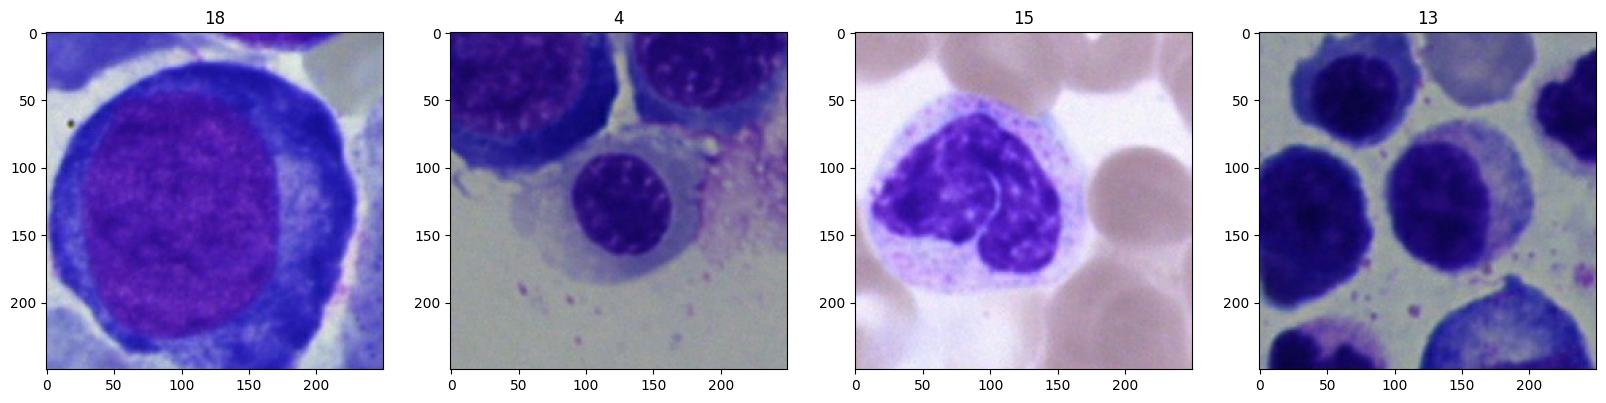

In [4]:
fig, ax = plt.subplots(ncols = 4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

3. Deep Model

3.1 Build Deep Learning Model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

model = Sequential()
# 16 filters, 3x3 size, stride of 1, 
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (250,250,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

# Fully connected layers
model.add(Dense(250, activation = 'relu'))
model.add(Dense(21, activation='softmax')) 

In [6]:
# Uses adam optimiser
model.compile('adam', loss = tf.losses.SparseCategoricalCrossentropy(),metrics = ['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 16)       0

3.2 Training

In [8]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [9]:
import time

t0 = time.time()
hist = model.fit(training_data, epochs = 20, validation_data = val_data, callbacks = [tensorboard_callback])
t1 = time.time()-t0

print('Training time: ', t1)

Epoch 1/20


2024-01-20 10:22:26.081935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2024-01-20 10:22:26.441753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:655] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-20 10:22:26.501355: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x559e4383f5a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-20 10:22:26.501382: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-01-20 10:22:26.506281: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-20 10:22:26.640689: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

511/513 [============================>.] - ETA: 0s - loss: 2.2724 - accuracy: 0.2688

2024-01-20 10:22:40.163102: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4101]
	 [[{{node Placeholder/_4}}]]
2024-01-20 10:22:40.163474: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4101]
	 [[{{node Placeholder/_4}}]]


513/513 [==============================] - 17s 27ms/step - loss: 2.2709 - accuracy: 0.2696 - val_loss: 2.0756 - val_accuracy: 0.3333
Epoch 2/20
513/513 [==============================] - 12s 24ms/step - loss: 1.8292 - accuracy: 0.4184 - val_loss: 1.8227 - val_accuracy: 0.4184
Epoch 3/20
513/513 [==============================] - 12s 24ms/step - loss: 1.5349 - accuracy: 0.5102 - val_loss: 1.6907 - val_accuracy: 0.4665
Epoch 4/20
513/513 [==============================] - 13s 24ms/step - loss: 1.2717 - accuracy: 0.5943 - val_loss: 1.7606 - val_accuracy: 0.4665
Epoch 5/20
513/513 [==============================] - 13s 24ms/step - loss: 1.0152 - accuracy: 0.6729 - val_loss: 1.9340 - val_accuracy: 0.4623
Epoch 6/20
513/513 [==============================] - 12s 24ms/step - loss: 0.7719 - accuracy: 0.7463 - val_loss: 2.2297 - val_accuracy: 0.4401
Epoch 7/20
513/513 [==============================] - 13s 25ms/step - loss: 0.5497 - accuracy: 0.8203 - val_loss: 2.6905 - val_accuracy: 0.4260
Epo

3.3 Plot Performance

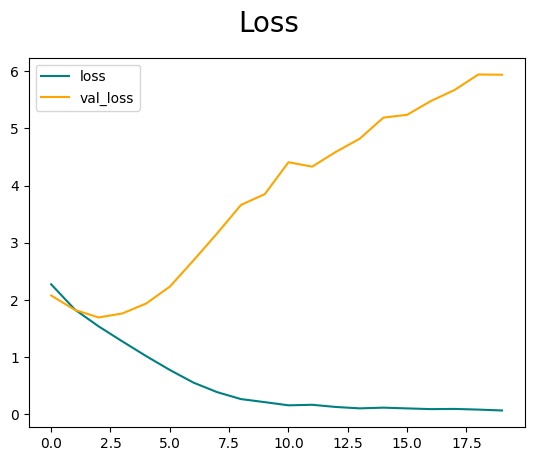

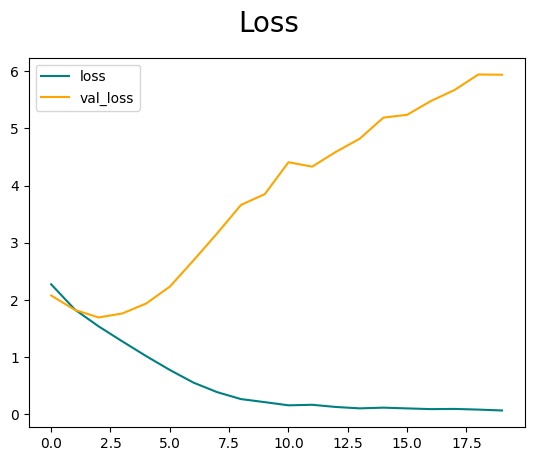

In [10]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = "upper left")
plt.show()

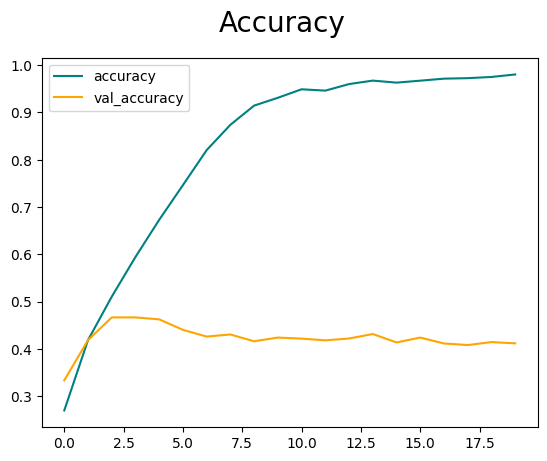

In [11]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = "upper left")
plt.show()

In [12]:
import pickle

folder = 'pickle'
inner_folder = 'first_model'

with open(os.path.join(folder, inner_folder, 'model_pickle'), 'wb') as f:
    pickle.dump(model, f)

In [13]:
with open(os.path.join(folder, inner_folder, 'history_pickle'), 'wb') as f:
    pickle.dump(hist.history, f)

4. Evaluate Performance

4.1 Evaluate

In [14]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [15]:
precision_per_class = [tf.keras.metrics.Precision(class_id=i) for i in range(21)]
recall_per_class = [tf.keras.metrics.Recall(class_id=i) for i in range(21)]
accuracy_per_class = [tf.keras.metrics.BinaryAccuracy(threshold=0.0) for _ in range(21)]

In [16]:
y_true = []
y_pred = []

for batch in val_data.as_numpy_iterator():
    image, y = batch
    y_one_hot = tf.one_hot(y, 21)
    yhat = model.predict(image)
    pre.update_state(y_one_hot, yhat)
    re.update_state(y_one_hot, yhat)
    acc.update_state(y_one_hot, yhat)
    
    y_true.extend(np.argmax(y_one_hot, axis = 1))
    y_pred.extend(np.argmax(yhat, axis = 1))

1/1 [==============================] - 0s 59ms/step


In [17]:
from sklearn.metrics import classification_report

print("Total")
print(f'Precision{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

y_true = np.array(y_true)
y_pred = np.array(y_pred)
class_labels = [str(i) for i in range(21)]
class_names = [label_to_class_mapping[label] for label in sorted(label_to_class_mapping.keys())]

# Generate classification report with specified labels
class_report = classification_report(y_true, y_pred, labels=class_labels, target_names=class_names)
print("Classification Report:\n", class_report)

Total
Precision0.4211464822292328, Recall:0.40307241678237915, Accuracy:0.9451934099197388
Classification Report:
               precision    recall  f1-score   support

         ABE       0.00      0.00      0.00         1
         ART       0.45      0.42      0.43       280
         BAS       0.11      0.10      0.10        61
         BLA       0.46      0.23      0.31       280
         EBO       0.60      0.55      0.58       280
         EOS       0.59      0.57      0.58       280
         FGC       0.00      0.00      0.00         6
         HAC       0.19      0.14      0.16        57
         KSC       0.00      0.00      0.00         6
         LYI       0.00      0.00      0.00         9
         LYT       0.49      0.49      0.49       280
         MMZ       0.30      0.21      0.25       280
         MON       0.30      0.24      0.27       280
         MYB       0.25      0.24      0.25       280
         NGB       0.26      0.43      0.32       280
         NGS       0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


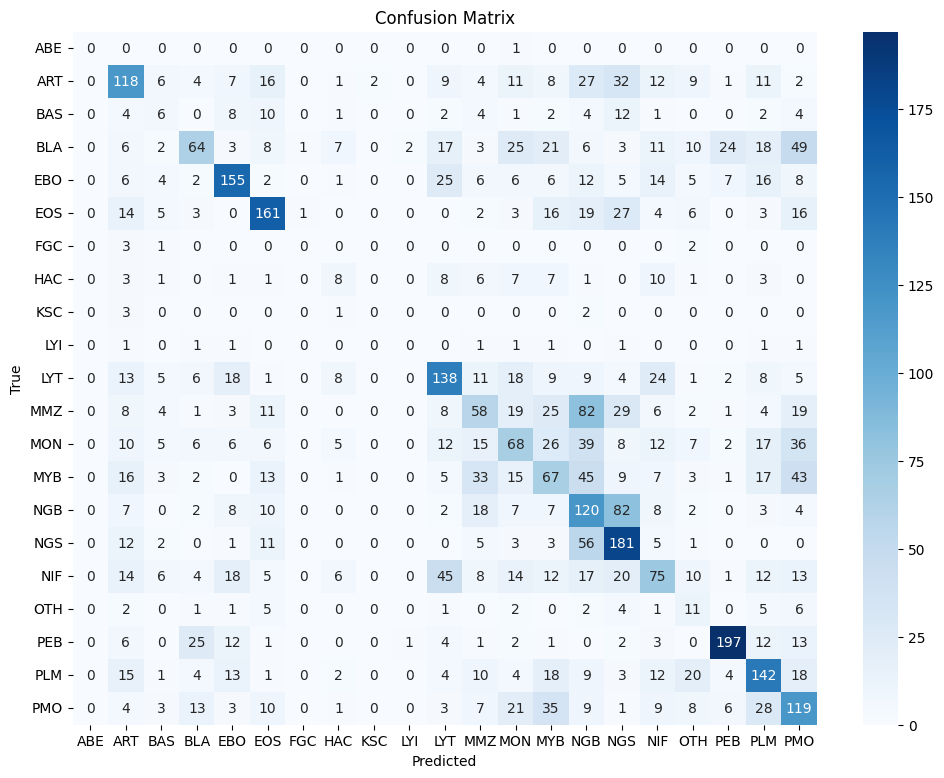

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

true_labels = np.argmax(y_one_hot, axis=1)
predicted_labels = np.argmax(yhat, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred, labels = list(range(21)))
plt.figure(figsize=(12, 9))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

confusion_data = {
    'conf_matrix': conf_matrix,
    'class_labels': class_names,
}

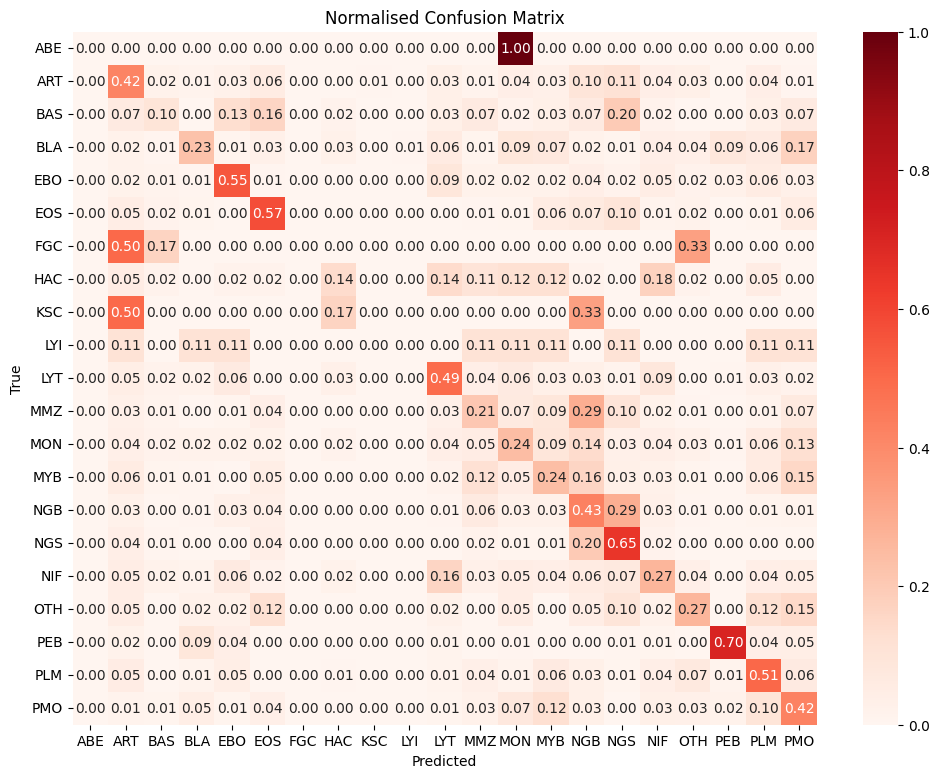

In [19]:
class_totals = np.sum(conf_matrix, axis=1)

normalised_conf_matrix = np.zeros_like(conf_matrix, dtype=float)
for i in range(len(class_totals)):
    if class_totals[i] != 0:
        normalised_conf_matrix[i, :] = conf_matrix[i, :] / class_totals[i]

# Plot the normalised confusion matrix with class names as tick labels
plt.figure(figsize=(12, 9))
sns.heatmap(normalised_conf_matrix, annot=True, fmt='.2f', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Confusion Matrix')
plt.show()

normalised_confusion_data = {
    'normalised_conf_matrix': normalised_conf_matrix,
    'class_labels': class_names,
}

5. Save the model

In [20]:
with open(os.path.join(folder, inner_folder, 'classification_report'), 'wb') as f:
    pickle.dump(class_report, f)
    
with open(os.path.join(folder, inner_folder,  'confusion_data'), 'wb') as f:
    pickle.dump(confusion_data, f)
    
with open(os.path.join(folder, inner_folder, 'normalised_confusion_data'), 'wb') as f:
    pickle.dump(normalised_confusion_data, f)